# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.812567,True,7.736697
1,1.826074,False,2.538347
2,2.022721,True,8.964443
3,0.259723,True,7.247494
4,1.819481,True,7.599879
...,...,...,...
995,-1.027437,True,5.177420
996,0.204471,False,0.139476
997,0.624099,False,3.705422
998,2.097327,True,8.699861


<AxesSubplot: xlabel='v0'>

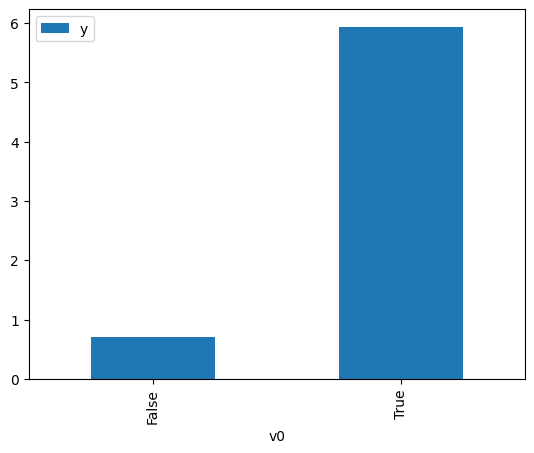

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

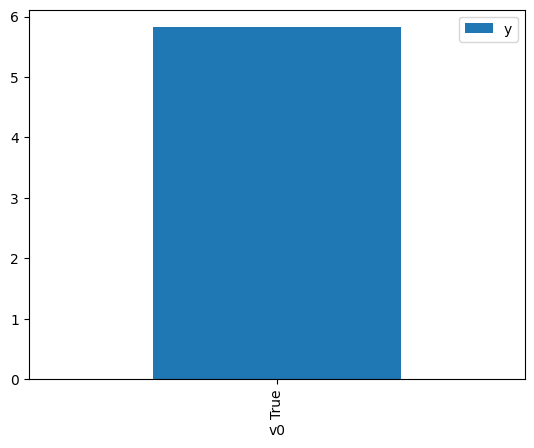

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.036307,False,-0.364898,0.509923,1.961081
1,-0.237895,False,0.240834,0.521839,1.916300
2,-0.235974,False,-0.389322,0.521725,1.916717
3,0.025510,False,0.432823,0.506266,1.975247
4,2.403741,False,3.789390,0.368688,2.712323
...,...,...,...,...,...
995,-0.553863,False,-1.710658,0.540461,1.850272
996,0.405261,False,1.113162,0.483801,2.066968
997,-1.501342,False,-3.372845,0.595431,1.679456
998,-0.413891,False,-2.181594,0.532222,1.878913


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.202312,True,4.533832,0.504196,1.983357
1,0.639143,True,8.749086,0.530009,1.886761
2,0.711031,True,7.216608,0.534245,1.871800
3,-0.780993,True,2.605185,0.446219,2.241053
4,-0.856166,True,4.430944,0.441826,2.263333
...,...,...,...,...,...
995,1.806006,True,9.741128,0.597815,1.672758
996,0.415797,True,5.878189,0.516822,1.934901
997,1.665519,True,9.456510,0.589795,1.695505
998,1.123874,True,6.963742,0.558460,1.790640


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.253e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        13:30:14   Log-Likelihood:                         -1384.1
No. Observations:                1000   AIC:                                      2772.
Df Residuals:                     998   BIC:                                      2782.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0447      0.030     67.241      0.000       1.985       2.104
x2             5.0037      0.045    109.975      0.000       4.914       5.093
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.413
Skew:                          -0.004   Prob(JB):                        0.814
Kurtosis:                       2.901   Cond. No.                         1.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""